In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import time

In [ ]:
def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

In [ ]:
def nw_naive(temp=1.0, unroll=10, batch=True, deepblast_bug=False):
  def sco(x, gap=0):
    def _soft_maximum(x,axis=0):
      return temp*jax.nn.logsumexp(x/temp,axis)
    # fill the scoring matrix
    def rows(pr,r):
      def cols(pc,c):
        # |------|-------|
        # | pc[0]| pc[1] |
        # |------|-------|
        # | c[0] | c[1]  |
        # |------|-------|
        if deepblast_bug:
          Align = pc[0] + c[1]
          Right = c[0]  + c[1] + gap
          Down  = pc[1] + c[1] + gap
        else:
          Align = pc[0] + c[1]
          Right = c[0]  + gap
          Down  = pc[1] + gap

        H = _soft_maximum(jnp.stack([Align, Right, Down]))
        return (c[0],H),H
      pr_r = jax.lax.scan(cols,(pr[1],r[1]),(pr[0],r[0]),unroll=unroll)[1]
      return (pr_r,r[1]), pr_r
    if deepblast_bug:
      ini_col = jnp.zeros(x.shape[0])
      ini_row = jnp.zeros(x.shape[1])
    else:
      ini_col = gap * jnp.arange(1,x.shape[0]+1,dtype=jnp.float32)
      ini_row = gap * jnp.arange(1,x.shape[1]+1,dtype=jnp.float32)
    hij = jax.lax.scan(rows,(ini_row,0),(x,ini_col))[1]

    return hij[-1,-1]
  # traceback to get alignment (aka. get marginals)
  traceback = jax.grad(sco)
  
  # add batch dimension
  if batch: return jax.vmap(traceback)
  else: return traceback

In [ ]:
def nw(unroll=2):
  # rotate matrix for vectorized dynamic-programming
  def rotate(x, lengths, gap, temp):
    def _ini_global(L):
      return gap*jnp.arange(L)

    a,b = x.shape
    real_a, real_b = lengths
    mask = (jnp.arange(a)<real_a)[:,None] * (jnp.arange(b)<real_b)[None,:]
    
    real_L = lengths
    mask = jnp.pad(mask,[[1,0],[1,0]])
    x = jnp.pad(x,[[1,0],[1,0]])
    
    # solution from jake vanderplas (thanks!)
    a,b = x.shape
    ar,br = jnp.arange(a)[::-1,None], jnp.arange(b)[None,:]
    i,j = (br-ar)+(a-1),(ar+br)//2
    n,m = (a+b-1),(a+b)//2
    zero = jnp.zeros((n,m))
    output = {"x":zero.at[i,j].set(x),
              "mask":zero.at[i,j].set(mask),
              "o":(jnp.arange(n)+a%2)%2}
    
    ini_a, ini_b = _ini_global(a), _ini_global(b)      
    ini = jnp.zeros((a,b)).at[:,0].set(ini_a).at[0,:].set(ini_b)
    output["ini"] = zero.at[i,j].set(ini)

    return {"x":output,
            "prev":(jnp.zeros(m),jnp.zeros(m)),
            "idx":(i,j),
            "mask":mask,
            "L":real_L}

  # fill the scoring matrix
  def sco(x, lengths, gap=0.0, temp=1.0):

    def _logsumexp(x, axis=None, mask=None):
      if mask is None: return jax.nn.logsumexp(x,axis=axis)
      else: return x.max(axis) + jnp.log(jnp.sum(mask * jnp.exp(x - x.max(axis,keepdims=True)),axis=axis))

    def _soft_maximum(x, axis=None, mask=None):
      return temp*_logsumexp(x/temp, axis, mask)

    def _cond(cond, true, false):
      return cond*true + (1-cond)*false

    def _step(prev, sm): 
      h2,h1 = prev   # previous two rows of scoring (hij) mtx
      
      Align = h2 + sm["x"]
      Turn = _cond(sm["o"],jnp.pad(h1[:-1],[1,0]),jnp.pad(h1[1:],[0,1]))
      h0 = [Align, h1+gap, Turn+gap]
      h0 = jnp.stack(h0)
      h0 = sm["mask"] * _soft_maximum(h0,0)
      h0 += sm["ini"]
      return (h1,h0),h0

    a,b = x.shape
    sm = rotate(x, lengths=lengths, gap=gap, temp=temp)
    hij = jax.lax.scan(_step, sm["prev"], sm["x"], unroll=unroll)[-1][sm["idx"]]

    return hij[sm["L"][0],sm["L"][1]]

  # traceback to get alignment (aka. get marginals)
  traceback = jax.grad(sco)

  # add batch dimension
  return jax.vmap(traceback,(0,0,None,None))

In [ ]:
def sw(unroll=2, batch=True, NINF=-1e30):
  '''smith-waterman (local alignment)'''

  # rotate matrix for striped dynamic-programming
  def rotate(x):   
    # solution from jake vanderplas (thanks!)
    a,b = x.shape
    ar,br = jnp.arange(a)[::-1,None], jnp.arange(b)[None,:]
    i,j = (br-ar)+(a-1),(ar+br)//2
    n,m = (a+b-1),(a+b)//2
    output = {"x":jnp.full([n,m],NINF).at[i,j].set(x), "o":(jnp.arange(n)+a%2)%2}
    return output, (jnp.full(m, NINF), jnp.full(m, NINF)), (i,j)

  # comute scoring (hij) matrix
  def sco(x, lengths, gap=0, temp=1.0):

    def _soft_maximum(x, axis=None, mask=None):
      def _logsumexp(y):
        if mask is None: return jax.nn.logsumexp(y, axis=axis)
        else: return y.max(axis) + jnp.log(jnp.sum(mask * jnp.exp(y - y.max(axis, keepdims=True)), axis=axis))
      return temp*_logsumexp(x/temp)
    
    def _cond(cond, true, false): return cond*true + (1-cond)*false
    def _pad(x,shape): return jnp.pad(x,shape,constant_values=(NINF,NINF))

    def _step(prev, sm):      
      h2,h1 = prev   # previous two rows of scoring (hij) mtx
      h1_T = _cond(sm["o"],_pad(h1[:-1],[1,0]),_pad(h1[1:],[0,1]))
      
      # directions
      Align = h2 + sm["x"]
      Turn_0 = h1 + gap
      Turn_1 = h1_T + gap
      Sky = sm["x"]

      h0 = jnp.stack([Align, Turn_0, Turn_1, Sky], -1)
      h0 = _soft_maximum(h0, -1)
      return (h1,h0),h0

    # mask
    a,b = x.shape
    real_a, real_b = lengths
    mask = (jnp.arange(a) < real_a)[:,None] * (jnp.arange(b) < real_b)[None,:]
    x = x + NINF * (1 - mask)

    sm, prev, idx = rotate(x[:-1,:-1])
    hij = jax.lax.scan(_step, prev, sm, unroll=unroll)[-1][idx]
    return _soft_maximum(hij + x[1:,1:], mask=mask[1:,1:])

  # traceback (aka backprop) to get alignment
  traceback = jax.grad(sco)

  # add batch dimension
  if batch: return jax.vmap(traceback,(0,0,None,None))
  else: return traceback

In [ ]:
def test(app, app_mode="jax", mode="len", trials=1, add_lengths=False, mx=1000):
  compile_time = []
  run_time = []
  for k in range(100,mx,100):
    if mode == "len": shape = [128,k,k]
    if mode == "batch": shape = [k,256,256]
    if app_mode == "jax":
      clear_mem()
      data = jnp.ones(shape,dtype=jnp.float32)
    if app_mode == "torch":
      torch.cuda.empty_cache()
      data = torch.ones(shape,dtype=torch.float32).cuda()

    if add_lengths and app_mode == "jax":
      if mode == "len":
        lens = jnp.full((128,2),k,dtype=jnp.int32)
      if mode == "batch":
        lens = jnp.full((k,2),256,dtype=jnp.int32)

    t = time.time()
    if add_lengths and app_mode == "jax":
      _ = app(data, lens, 0.0, 1.0)
    else:
      _ = app(data)
    compile_time.append(time.time() - t)
    t = time.time()
    for _ in range(trials):
      if add_lengths and app_mode == "jax":
        _ = app(data, lens, 0.0, 1.0)
      else:
        _ = app(data)
    run_time.append((time.time() - t)/trials)
    print(k,compile_time[-1]-run_time[-1],run_time[-1])
  return np.array([compile_time,run_time])

In [ ]:
!pip -q install deepblast

In [ ]:
import torch
from deepblast.nw_cuda import NeedlemanWunschDecoder
import time

In [ ]:
needle_cuda = NeedlemanWunschDecoder("softmax")
needle_cuda.cuda()

In [ ]:
def forward_test(theta, gap=0):
  theta.requires_grad_()
  gap_mtx = torch.full_like(theta, fill_value=gap, dtype=torch.float32)
  sco = needle_cuda(theta, gap_mtx).sum()
  sco.backward()
  path = theta.grad
  return path

def backward_test(theta, gap=0):
  # forward and backward
  theta.requires_grad_()
  gap_mtx = torch.full_like(theta, fill_value=gap, dtype=torch.float32)
  sco = needle_cuda(theta, gap_mtx).sum()
  sco_sco = torch.autograd.grad(sco,theta,create_graph=True)[0].sum()
  sco_sco.backward()
  return theta.grad

In [ ]:
nw_pytorch_time_fwd_len = test(forward_test, app_mode="torch", mode="len")
nw_pytorch_time_fwd_batch = test(forward_test, app_mode="torch", mode="batch")

In [ ]:
nw_pytorch_time_bwd_len = test(backward_test, app_mode="torch", mode="len")
nw_pytorch_time_bwd_batch = test(backward_test, app_mode="torch", mode="batch")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
nw_naive_jax_time_fwd_len = test(jax.jit(nw_naive()), mode="len")
nw_jax_time_fwd_len = test(jax.jit(nw()), mode="len", add_lengths=True)
sw_jax_time_fwd_len = test(jax.jit(sw()), mode="len", add_lengths=True)

In [ ]:
nw_naive_jax_time_bwd_len = test(jax.jit(jax.grad(lambda x: nw_naive()(x).sum())), mode="len")
nw_jax_time_bwd_len = test(jax.jit(jax.grad(lambda w,x,y,z: nw()(w,x,y,z).sum())), mode="len", add_lengths=True,mx=800)
sw_jax_time_bwd_len = test(jax.jit(jax.grad(lambda w,x,y,z: sw()(w,x,y,z).sum())), mode="len", add_lengths=True,mx=800)

In [ ]:
nw_naive_jax_time_fwd_batch = test(jax.jit(nw_naive()), mode="batch")
nw_jax_time_fwd_batch = test(jax.jit(nw()), mode="batch", add_lengths=True)
sw_jax_time_fwd_batch = test(jax.jit(sw()), mode="batch", add_lengths=True)

In [ ]:
nw_naive_jax_time_bwd_batch = test(jax.jit(jax.grad(lambda x: nw_naive()(x).sum())), mode="batch")
nw_jax_time_bwd_batch = test(jax.jit(jax.grad(lambda w,x,y,z: nw()(w,x,y,z).sum())), mode="batch", add_lengths=True)
sw_jax_time_bwd_batch = test(jax.jit(jax.grad(lambda w,x,y,z: sw()(w,x,y,z).sum())), mode="batch", add_lengths=True)

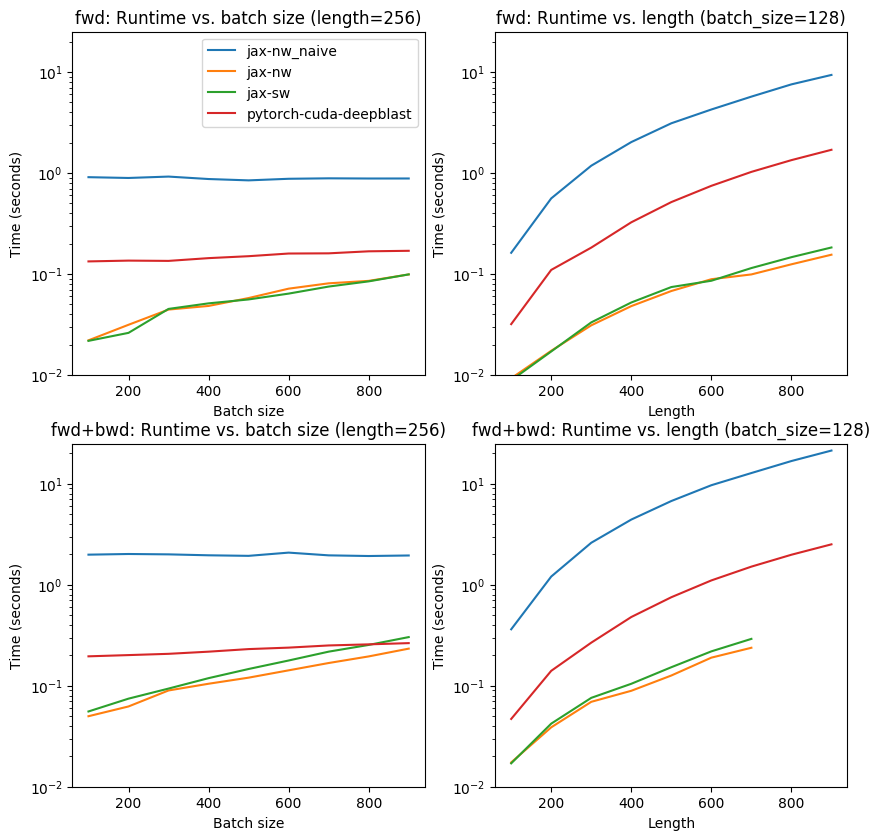

In [32]:
plt.figure(figsize=(10,10),dpi=100)
plt.subplot(2,2,1)
plt.title("fwd: Runtime vs. batch size (length=256)")
plt.plot(np.arange(100,1000,100),nw_naive_jax_time_fwd_batch[1],label="jax-nw_naive")
plt.plot(np.arange(100,1000,100),nw_jax_time_fwd_batch[1],label="jax-nw")
plt.plot(np.arange(100,1000,100),sw_jax_time_fwd_batch[1],label="jax-sw")
plt.plot(np.arange(100,1000,100),nw_pytorch_time_fwd_batch[1],label="pytorch-cuda-deepblast")
plt.xlabel("Batch size")
plt.ylabel("Time (seconds)")
plt.yscale("log")
plt.ylim(0.01,25.0)
plt.legend()

plt.subplot(2,2,2)
plt.title("fwd: Runtime vs. length (batch_size=128)")
plt.plot(np.arange(100,1000,100),nw_naive_jax_time_fwd_len[1],label="jax-nw_naive")
plt.plot(np.arange(100,1000,100),nw_jax_time_fwd_len[1],label="jax-nw")
plt.plot(np.arange(100,1000,100),sw_jax_time_fwd_len[1],label="jax-sw")
plt.plot(np.arange(100,1000,100),nw_pytorch_time_fwd_len[1],label="pytorch-cuda-deepblast")
plt.xlabel("Length")
plt.ylabel("Time (seconds)")
plt.yscale("log")
plt.ylim(0.01,25.0)

plt.subplot(2,2,3)
plt.title("fwd+bwd: Runtime vs. batch size (length=256)")
plt.plot(np.arange(100,1000,100),nw_naive_jax_time_bwd_batch[1],label="jax-nw_naive")
plt.plot(np.arange(100,1000,100),nw_jax_time_bwd_batch[1],label="jax-nw")
plt.plot(np.arange(100,1000,100),sw_jax_time_bwd_batch[1],label="jax-sw")
plt.plot(np.arange(100,1000,100),nw_pytorch_time_bwd_batch[1],label="pytorch-cuda-deepblast")
plt.xlabel("Batch size")
plt.ylabel("Time (seconds)")
plt.yscale("log")
plt.ylim(0.01,25.0)
plt.subplot(2,2,4)
plt.title("fwd+bwd: Runtime vs. length (batch_size=128)")
plt.plot(np.arange(100,1000,100),nw_naive_jax_time_bwd_len[1],label="jax-nw_naive")
plt.plot(np.arange(100,800,100),nw_jax_time_bwd_len[1],label="jax-nw")
plt.plot(np.arange(100,800,100),sw_jax_time_bwd_len[1],label="jax-sw")
plt.plot(np.arange(100,1000,100),nw_pytorch_time_bwd_len[1],label="pytorch-cuda-deepblast")
plt.xlabel("Length")
plt.ylabel("Time (seconds)")
plt.yscale("log")
plt.ylim(0.01,25.0)
plt.savefig("speedtest.pdf",bbox_inches='tight')
plt.show()

In [34]:
!nvidia-smi

Fri Oct  1 17:08:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:19:00.0 Off |                  N/A |
|  0%   29C    P8    23W / 280W |  22020MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:1A:00.0 Off |                  N/A |
|  0%   29C    P8    24W / 280W |  22066MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T